## Load the dataset and Import the necessary libraries 

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve
from dmba import classificationSummary
import matplotlib.pyplot as plt
%matplotlib inline

# Load the dataset
df = pd.read_csv('enriched_high_elo_games.csv')

## Encode the outcome variable: 1 for White win ("1-0"), 0 otherwise

In [73]:
df['white_win'] = df['result'].apply(lambda x: 1 if x == '1-0' else 0)
print("Outcome distribution:")
print(df['white_win'].value_counts(normalize=True))

Outcome distribution:
white_win
0    0.502
1    0.498
Name: proportion, dtype: float64


## Filter ECO codes with sufficient games

In [74]:
min_games = 5  # Minimum number of games per ECO code
eco_counts = df['eco'].value_counts()
valid_eco = eco_counts[eco_counts >= min_games].index
df_filtered = df[df['eco'].isin(valid_eco)]
print(f"\nNumber of ECO codes with at least {min_games} games: {len(valid_eco)}")
print(f"Filtered dataset size: {df_filtered.shape[0]} (original: {df.shape[0]})")


Number of ECO codes with at least 5 games: 56
Filtered dataset size: 661 (original: 1000)


## Calculate White win rate by ECO code

In [75]:
win_by_eco = df_filtered.groupby('eco')['white_win'].mean().sort_values(ascending=False)
print("\nTop 10 White Win Rates by ECO (filtered):")
print(win_by_eco.head(10))


Top 10 White Win Rates by ECO (filtered):
eco
A13    1.000000
A20    0.857143
A10    0.727273
B06    0.714286
D02    0.705882
A46    0.692308
A04    0.666667
C45    0.666667
B31    0.666667
B90    0.666667
Name: white_win, dtype: float64


## Plot White win rates

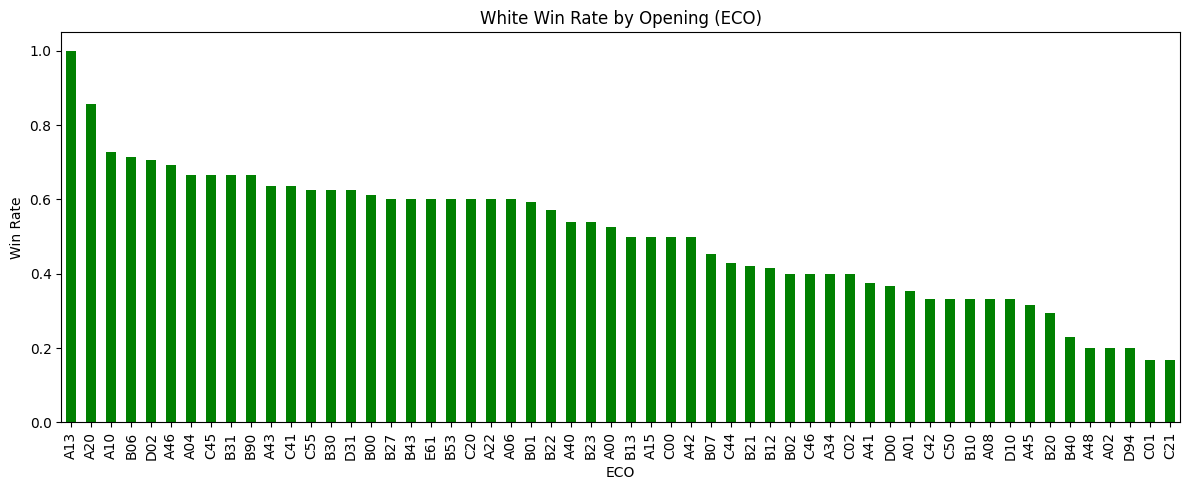

In [76]:
plt.figure(figsize=(12, 5))
win_by_eco.plot(kind='bar', color='green')
plt.title('White Win Rate by Opening (ECO)')
plt.ylabel('Win Rate')
plt.xlabel('ECO')
plt.tight_layout()
plt.show()

### Prepare predictors for logistic regression & Handle missing data with Imputation Drop rowns if necessary

In [77]:
predictors = [
    'white_elo', 'black_elo', 'time_control', 'termination', 'eco',
    'white_preferred_game', 'black_preferred_game', 'white_total_wins', 'black_total_wins'
]
outcome = 'white_win'

print("\nMissing values in filtered dataset:")
print(df_filtered[predictors + [outcome]].isna().sum())

df_filtered = df_filtered.copy()

numerical_cols = ['white_elo', 'black_elo', 'white_total_wins', 'black_total_wins']
for col in numerical_cols:
    df_filtered[col] = df_filtered[col].fillna(df_filtered[col].median())

df_filtered = df_filtered.dropna(subset=[
    'time_control', 'termination', 'eco', 'white_preferred_game', 'black_preferred_game', outcome
])


Missing values in filtered dataset:
white_elo               0
black_elo               0
time_control            0
termination             0
eco                     0
white_preferred_game    0
black_preferred_game    0
white_total_wins        0
black_total_wins        0
white_win               0
dtype: int64


## Encode categorical variables & Split data

In [78]:
X = pd.get_dummies(df_filtered[predictors], columns=['time_control', 'termination', 'eco', 'white_preferred_game', 'black_preferred_game'], drop_first=True)
y = df_filtered[outcome]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 528
Test set size: 133


## Fit logistic regression model & Display coefficients

In [87]:
logit_reg = LogisticRegression(max_iter=5000, solver='liblinear')
logit_reg.fit(X_train, y_train)

coefs = pd.DataFrame(
    data={'Coefs': np.concatenate((logit_reg.intercept_, logit_reg.coef_[0]))},
    index=np.concatenate((['Intercept'], X_train.columns))
)

print("\nLogistic Regression Coefficients (first 10):")
print(coefs.head(10))


Logistic Regression Coefficients (first 10):
                           Coefs
Intercept           8.304845e-02
white_elo           5.687816e-03
black_elo          -5.411601e-03
white_total_wins   -3.640480e-07
black_total_wins    7.012459e-06
time_control_0+1    1.398489e-02
time_control_0+3    0.000000e+00
time_control_120+0 -1.902700e-01
time_control_120+1  4.791825e-01
time_control_120+2 -1.011163e-01


## Predict probabilities & Classes 

In [80]:
pred_logitreg = pd.DataFrame(
    logit_reg.predict_proba(X_test),
    columns=logit_reg.classes_
)
print("\nPredicted Probabilities (first 5 rows):")
print(pred_logitreg.head())

y_pred = logit_reg.predict(X_test)


Predicted Probabilities (first 5 rows):
          0         1
0  0.502008  0.497992
1  0.648740  0.351260
2  0.566459  0.433541
3  0.277315  0.722685
4  0.382634  0.617366


## Confusion matrix 

In [81]:
print("\nConfusion Matrix for Logistic Regression:")
classificationSummary(y_test, y_pred, class_names=['Not White Win', 'White Win'])


Confusion Matrix for Logistic Regression:
Confusion Matrix (Accuracy 0.6391)

              Prediction
       Actual Not White Win     White Win
Not White Win            41            31
    White Win            17            44


## ROC curve


ROC Data (first 5 rows):
     recall  specificity  thresholds
0  0.000000     1.000000         inf
1  0.016393     1.000000    0.984574
2  0.081967     1.000000    0.939657
3  0.081967     0.986111    0.939282
4  0.114754     0.986111    0.923654


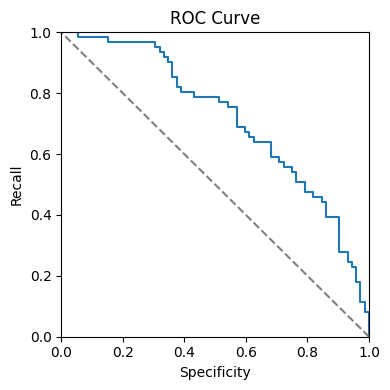

In [82]:
fpr, tpr, thresholds = roc_curve(y_test, logit_reg.predict_proba(X_test)[:, 1])
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr, 'thresholds': thresholds})
print("\nROC Data (first 5 rows):")
print(roc_df.head())

# Plot ROC curve
plt.figure(figsize=(4, 4))
plt.plot(roc_df['specificity'], roc_df['recall'], label='ROC Curve')
plt.plot([1, 0], [0, 1], linestyle='--', color='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Specificity')
plt.ylabel('Recall')
plt.title('ROC Curve')
plt.tight_layout()
plt.show()

# Calculate AUROC

In [83]:
auroc = round(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)), 2)
print(f"AUROC: {auroc}")

AUROC: 0.72


## Display Confusion Matrix

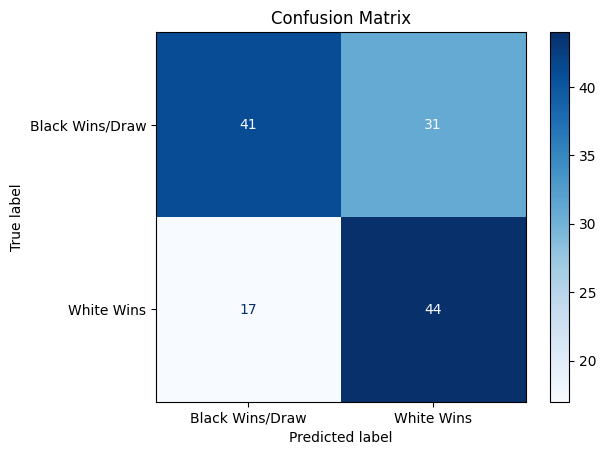

In [84]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Black Wins/Draw', 'White Wins'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()